In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)


In [2]:
device = "cuda:4"

class Net(nn.Module):
    #simple MLP
    def __init__(self):
        super(Net, self).__init__()
        self.fc1 = nn.Linear(10,1000, bias=True)
        self.fc2 = nn.Linear(1000,1000, bias=True)
        self.fc3 = nn.Linear(1000,2, bias=True)

    def forward(self, x):
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = self.fc3(x)
        return x
    
    
x = (torch.rand(10000,10).to(device)-0.5)*2*3.14159

y = torch.stack([
    torch.sin(torch.sum(x[:,[0]], dim=1)),
    torch.cos(torch.sum(x[:,[1]], dim=1))
])

y = y.T.to(device)

model = Net().to(device)

criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

for epoch in range(2500):
    optimizer.zero_grad()
    output = model(x)
    loss = criterion(output, y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(epoch, loss.item())





0 0.5590739846229553
100 0.0643826276063919
200 0.008838595822453499
300 0.0037331266794353724
400 0.002800795016810298
500 0.002221751492470503
600 0.0018054868560284376
700 0.0015732740284875035
800 0.00139450968708843
900 0.0012513110414147377
1000 0.0012612884165719151
1100 0.0011944144498556852
1200 0.0019212185870856047
1300 0.0008573938393965364
1400 0.0007810938404873013
1500 0.0007567660650238395
1600 0.0006648564012721181
1700 0.0006206691614352167
1800 0.0006639884668402374
1900 0.0005827266722917557
2000 0.0006724837003275752
2100 0.0015476939734071493
2200 0.000507165736053139
2300 0.0004710083012469113
2400 0.00044184751459397376


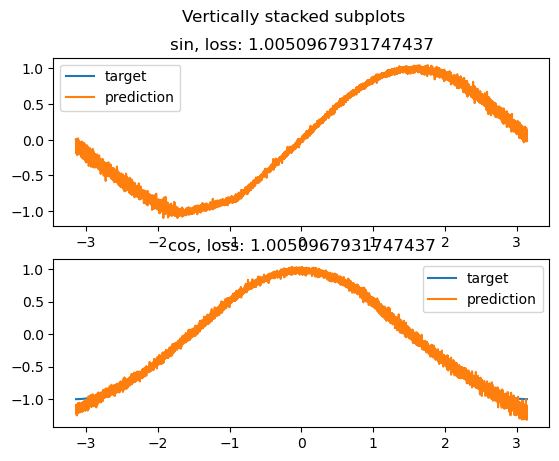

In [3]:
import matplotlib.pyplot as plt

def plot(model, x):
    # import matplotlib.pyplot as plt
    # import numpy as np
    with torch.no_grad():
        y_pred = model(x)

    y_target = torch.stack([
            torch.sin(torch.sum(x[:,[0]], dim=1)),
            torch.cos(torch.sum(x[:,[1]], dim=1))
        ])

    #create two subplots
    fig, axs = plt.subplots(2)
    fig.suptitle('Vertically stacked subplots')
    idx_1 = torch.argsort(torch.sum(x[:,[0]], dim=1))
    x_1 = torch.sum(x[:,[0]], dim=1)[idx_1]
    idx_2 = torch.argsort(torch.sum(x[:,[1]], dim=1))
    x_2 = torch.sum(x[:,[1]], dim=1)[idx_2]

    axs[0].plot(x_1.to("cpu").numpy(), y_target[0][idx_1].to("cpu").numpy(), label="target")
    axs[0].plot(x_1.to("cpu").numpy(), y_pred[idx_1,0].to("cpu").numpy(), label="prediction")
    axs[0].set_title(f'sin, loss: {criterion(y_pred, y).item()}')
    axs[0].legend()

    axs[1].plot(x_2.to("cpu").numpy(), y_target[1][idx_2].to("cpu").numpy(), label="target")
    axs[1].plot(x_2.to("cpu").numpy(), y_pred[idx_2,1].to("cpu").numpy(), label="prediction")
    axs[1].set_title(f'cos, loss: {criterion(y_pred, y).item()}')
    axs[1].legend()

    # return fig

    

x_test = 2*np.pi*(torch.rand(10000,10).to(device)-0.5)

plot(model, x_test)

In [4]:
import src.linear_compress as lc
import src.quantizers.vector_quantizer as vq
import src.quantizers.vq2 as vq2
import copy

#compress the model
model_to_compress_vq = Net()
model_to_compress_vq2 = Net()

model_to_compress_vq.load_state_dict(copy.deepcopy(model.state_dict()))
model_to_compress_vq2.load_state_dict(copy.deepcopy(model.state_dict()))


for name, layer in model_to_compress_vq.named_children():
    if isinstance(layer, nn.Linear):
        setattr(model_to_compress_vq, name, lc.LinearQuantized(layer.weight, layer.bias))
        setattr(model_to_compress_vq2, name, lc.LinearQuantized(layer.weight, layer.bias))


        getattr(model_to_compress_vq, name).to(device)
        getattr(model_to_compress_vq2, name).to(device)


        #turn on hessian logging for both
        getattr(model_to_compress_vq, name).enable_hessian_logging()
        getattr(model_to_compress_vq2, name).enable_hessian_logging()
        # layer = lc.LinearQuantized(layer.weight, layer.bias)

model_to_compress_vq.to(device)
model_to_compress_vq2.to(device)
print(model_to_compress_vq)


calibration_set = 2*np.pi*(torch.rand(128,10).to(device)-0.5)

with torch.no_grad():
    model_to_compress_vq(calibration_set)
    model_to_compress_vq2(calibration_set)

print(model_to_compress_vq.fc1.hessian)

Net(
  (fc1): LinearQuantized()
  (fc2): LinearQuantized()
  (fc3): LinearQuantized()
)
tensor([[ 6.4168, -0.1243, -0.1509, -0.9977,  0.0283,  0.2623,  0.0808,  0.2722,
          0.5028,  0.5577],
        [-0.1243,  6.3219,  0.3463, -0.1254, -0.2362, -0.2127,  0.3283, -0.2399,
         -0.1829, -0.3596],
        [-0.1509,  0.3463,  6.7596,  1.0587, -0.5177,  1.2497, -1.1736,  0.5639,
         -0.3915, -0.3143],
        [-0.9977, -0.1254,  1.0587,  6.6771,  0.4033, -0.0170, -0.1538, -0.7880,
         -0.2512,  0.9357],
        [ 0.0283, -0.2362, -0.5177,  0.4033,  6.2570, -0.7925, -0.2364, -0.0629,
          0.2333, -0.9442],
        [ 0.2623, -0.2127,  1.2497, -0.0170, -0.7925,  7.2655,  0.0113,  1.4661,
         -0.7290,  0.5849],
        [ 0.0808,  0.3283, -1.1736, -0.1538, -0.2364,  0.0113,  6.9324,  0.3196,
          0.3723,  0.2073],
        [ 0.2722, -0.2399,  0.5639, -0.7880, -0.0629,  1.4661,  0.3196,  7.5845,
          0.5757,  0.0115],
        [ 0.5028, -0.1829, -0.3915, -0.2

/home/lliu/anaconda3/lib/python3.11/site-packages/torch/jit/annotations.py:389: UserWarning: TorchScript will treat type annotations of Tensor dtype-specific subtypes as if they are normal Tensors. dtype constraints are not enforced in compilation either.
  warnings.warn(


In [5]:
import yaml
kwargs = yaml.load(open("/data/lliu/huffman/scripts/1layer_compress/quantizer_args.yaml", "r"), Loader=yaml.FullLoader)

print(kwargs["quantizer_kwargs"])

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

for name in ["fc1", "fc2", "fc3"]:
    # if isinstance(layer, lc.LinearQuantized):
    #     print(name, parameter.quantizer_kwargs)


    getattr(model_to_compress_vq, name).quantize(vq.VectorQuantizer, **kwargs["quantizer_kwargs"])
    getattr(model_to_compress_vq,name).align(eps = 0, **kwargs["alignment_kwargs"])
    # getattr(model_to_compress_vq2, name).quantize(vq2.VectorQuantizer_1st_order, **kwargs["quantizer_kwargs"])

{'d': 4, 'n_bits': 2, 'cluster_ignore_norms': True, 'n_iters': 100, 'norm_order': [0, 1], 'zero': [False, False], 'initialize_method': 'kmeans'}
hessian torch.Size([10, 10])
padding 2
hesian torch.Size([12, 12])
256


 20%|██        | 20/100 [00:02<00:10,  7.63it/s]


False
here
discrete_update_every 100000
iter 0/500, train loss 90.53300476074219, val loss None, lr 0.001 best_state_dict_idx 0
iter 10/500, train loss 51.680259704589844, val loss None, lr 0.001 best_state_dict_idx 10
iter 20/500, train loss 29.574665069580078, val loss None, lr 0.001 best_state_dict_idx 20
iter 30/500, train loss 15.639139175415039, val loss None, lr 0.001 best_state_dict_idx 30
iter 40/500, train loss 7.319426536560059, val loss None, lr 0.001 best_state_dict_idx 40
iter 50/500, train loss 2.8055355548858643, val loss None, lr 0.001 best_state_dict_idx 50
iter 60/500, train loss 0.7547709345817566, val loss None, lr 0.001 best_state_dict_idx 60
iter 70/500, train loss 0.12756839394569397, val loss None, lr 0.001 best_state_dict_idx 70
iter 80/500, train loss 0.0295749269425869, val loss None, lr 0.001 best_state_dict_idx 80
iter 90/500, train loss 0.01447663176804781, val loss None, lr 0.001 best_state_dict_idx 90
iter 100/500, train loss 0.007026953622698784, val l

100%|██████████| 100/100 [00:08<00:00, 11.19it/s]


False
here
discrete_update_every 100000
iter 0/500, train loss 117.73274993896484, val loss None, lr 0.001 best_state_dict_idx 0
iter 10/500, train loss 34.295501708984375, val loss None, lr 0.001 best_state_dict_idx 9
iter 20/500, train loss 10.929323196411133, val loss None, lr 0.001 best_state_dict_idx 17
iter 30/500, train loss 10.354710578918457, val loss None, lr 0.001 best_state_dict_idx 29
iter 40/500, train loss 15.884008407592773, val loss None, lr 0.001 best_state_dict_idx 37
iter 50/500, train loss 7.848699569702148, val loss None, lr 0.001 best_state_dict_idx 50
iter 60/500, train loss 16.409175872802734, val loss None, lr 0.001 best_state_dict_idx 50
iter 70/500, train loss 13.943300247192383, val loss None, lr 0.001 best_state_dict_idx 67
iter 80/500, train loss 19.07575035095215, val loss None, lr 0.001 best_state_dict_idx 77
iter 90/500, train loss 6.718501091003418, val loss None, lr 0.001 best_state_dict_idx 77
iter 100/500, train loss 4.000401496887207, val loss Non

  3%|▎         | 3/100 [00:00<00:04, 21.95it/s]

False
here
discrete_update_every 100000
iter 0/500, train loss 1.9890625480911694e-05, val loss None, lr 0.001 best_state_dict_idx 0
iter 10/500, train loss 0.008411760441958904, val loss None, lr 0.001 best_state_dict_idx 0
iter 20/500, train loss 0.0025473707355558872, val loss None, lr 0.001 best_state_dict_idx 0


iter 30/500, train loss 0.0017337031895294785, val loss None, lr 0.001 best_state_dict_idx 0
iter 40/500, train loss 0.0003570151748135686, val loss None, lr 0.001 best_state_dict_idx 0
iter 50/500, train loss 0.00056316121481359, val loss None, lr 0.001 best_state_dict_idx 0
iter 60/500, train loss 0.0006788679165765643, val loss None, lr 0.001 best_state_dict_idx 0
iter 70/500, train loss 0.0012578510213643312, val loss None, lr 0.001 best_state_dict_idx 0
iter 80/500, train loss 0.005140576511621475, val loss None, lr 0.001 best_state_dict_idx 0
iter 90/500, train loss 0.00038147185114212334, val loss None, lr 0.001 best_state_dict_idx 0
iter 100/500, train loss 0.0012693554162979126, val loss None, lr 0.001 best_state_dict_idx 0
iter 110/500, train loss 0.004688294604420662, val loss None, lr 0.001 best_state_dict_idx 0
iter 120/500, train loss 0.0011460795067250729, val loss None, lr 0.001 best_state_dict_idx 0
iter 130/500, train loss 0.0019693418871611357, val loss None, lr 0.00

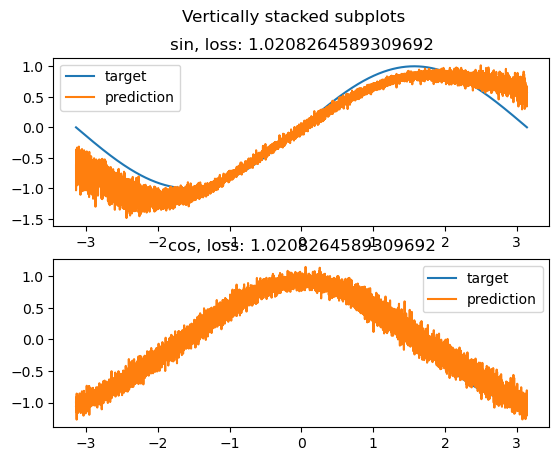

In [6]:
plot(model_to_compress_vq, x_test)

In [7]:

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

for name in ["fc1", "fc2", "fc3"]:
    # if isinstance(layer, lc.LinearQuantized):
    #     print(name, parameter.quantizer_kwargs)


    getattr(model_to_compress_vq2, name).quantize(vq2.VectorQuantizer_1st_order, **kwargs["quantizer_kwargs"])
    getattr(model_to_compress_vq2,name).align(eps = 0, **kwargs["alignment_kwargs"])
    # getattr(model_to_compress_vq2, name).update_discrete(**{"hessian": getattr(model_to_compress_vq2, name).hessian,
    #                                                       "n_parallel":4096})

hessian torch.Size([10, 10])
padding 2
hesian torch.Size([12, 12])
256


  8%|▊         | 8/100 [00:00<00:08, 11.24it/s]


False
here
discrete_update_every 100000
iter 0/500, train loss 21.604061126708984, val loss None, lr 0.001 best_state_dict_idx 0
iter 10/500, train loss 7.781684875488281, val loss None, lr 0.001 best_state_dict_idx 10
iter 20/500, train loss 3.3640918731689453, val loss None, lr 0.001 best_state_dict_idx 20
iter 30/500, train loss 1.1772043704986572, val loss None, lr 0.001 best_state_dict_idx 30
iter 40/500, train loss 0.34817928075790405, val loss None, lr 0.001 best_state_dict_idx 40
iter 50/500, train loss 0.09293752908706665, val loss None, lr 0.001 best_state_dict_idx 50
iter 60/500, train loss 0.018793515861034393, val loss None, lr 0.001 best_state_dict_idx 60
iter 70/500, train loss 0.0067131537944078445, val loss None, lr 0.001 best_state_dict_idx 70
iter 80/500, train loss 0.005373930558562279, val loss None, lr 0.001 best_state_dict_idx 77
iter 90/500, train loss 0.002159399911761284, val loss None, lr 0.001 best_state_dict_idx 90
iter 100/500, train loss 0.001958133885636

 76%|███████▌  | 76/100 [00:06<00:02, 11.25it/s]


False
here
discrete_update_every 100000
iter 0/500, train loss 49.2855224609375, val loss None, lr 0.001 best_state_dict_idx 0
iter 10/500, train loss 25.43639373779297, val loss None, lr 0.001 best_state_dict_idx 7
iter 20/500, train loss 9.898375511169434, val loss None, lr 0.001 best_state_dict_idx 20
iter 30/500, train loss 11.29129695892334, val loss None, lr 0.001 best_state_dict_idx 24
iter 40/500, train loss 11.915338516235352, val loss None, lr 0.001 best_state_dict_idx 33
iter 50/500, train loss 8.03110122680664, val loss None, lr 0.001 best_state_dict_idx 49
iter 60/500, train loss 41.54263687133789, val loss None, lr 0.001 best_state_dict_idx 49
iter 70/500, train loss 21.210617065429688, val loss None, lr 0.001 best_state_dict_idx 49
iter 80/500, train loss 20.981962203979492, val loss None, lr 0.001 best_state_dict_idx 49
iter 90/500, train loss 4.894557952880859, val loss None, lr 0.001 best_state_dict_idx 49
iter 100/500, train loss 5.667917251586914, val loss None, lr 

  3%|▎         | 3/100 [00:00<00:04, 22.02it/s]

False
here
discrete_update_every 100000
iter 0/500, train loss 1.9890625480911694e-05, val loss None, lr 0.001 best_state_dict_idx 0
iter 10/500, train loss 0.008411760441958904, val loss None, lr 0.001 best_state_dict_idx 0


iter 20/500, train loss 0.0025473707355558872, val loss None, lr 0.001 best_state_dict_idx 0
iter 30/500, train loss 0.0017337031895294785, val loss None, lr 0.001 best_state_dict_idx 0
iter 40/500, train loss 0.0003570151748135686, val loss None, lr 0.001 best_state_dict_idx 0
iter 50/500, train loss 0.00056316121481359, val loss None, lr 0.001 best_state_dict_idx 0
iter 60/500, train loss 0.0006788679165765643, val loss None, lr 0.001 best_state_dict_idx 0
iter 70/500, train loss 0.0012578510213643312, val loss None, lr 0.001 best_state_dict_idx 0
iter 80/500, train loss 0.005140576511621475, val loss None, lr 0.001 best_state_dict_idx 0
iter 90/500, train loss 0.00038147185114212334, val loss None, lr 0.001 best_state_dict_idx 0
iter 100/500, train loss 0.0012693554162979126, val loss None, lr 0.001 best_state_dict_idx 0
iter 110/500, train loss 0.004688294604420662, val loss None, lr 0.001 best_state_dict_idx 0
iter 120/500, train loss 0.0011460795067250729, val loss None, lr 0.001

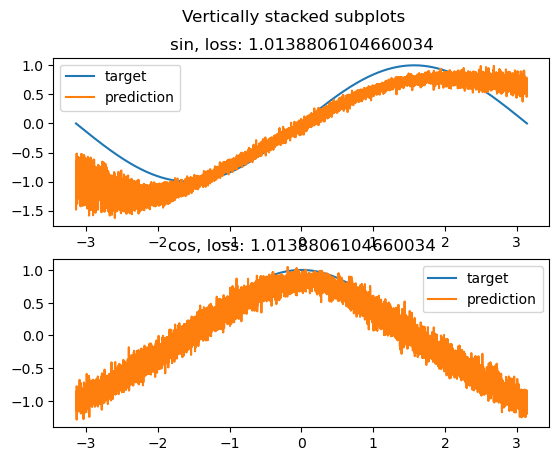

In [8]:
plot(model_to_compress_vq2, x_test)

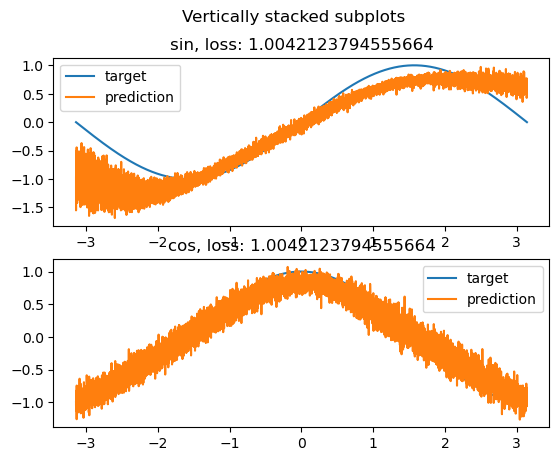

In [9]:

torch.manual_seed(0)
torch.cuda.manual_seed(0)
np.random.seed(0)

for name in ["fc1", "fc2", "fc3"]:
    # if isinstance(layer, lc.LinearQuantized):
    #     print(name, parameter.quantizer_kwargs)


    # getattr(model_to_compress_vq2, name).quantize(vq2.VectorQuantizer_1st_order, **kwargs["quantizer_kwargs"])
    # getattr(model_to_compress_vq2,name).align(eps = 0, **kwargs["alignment_kwargs"])
    print("n_change:",getattr(model_to_compress_vq2, name).update_discrete(**{"hessian": getattr(model_to_compress_vq2, name).hessian,
                                                          "n_parallel":4096}))

plot(model_to_compress_vq2, x_test)

In [ ]:
import torch 
import torch.nn as nn


mask = torch.rand((10,10))>0.2
print(mask)

class Net(nn.Module):
    #simple MLP
    def __init__(self):
        super(Net, self).__init__()
        t = torch.zeros((10,10))
        t[mask] = torch.rand(torch.sum(mask))
        self.t = nn.Parameter(t.to_sparse_csr())
    
    def forward(self, x):
        
        return torch.einsum("ij,jk,ik->i", x, self.t, x)
    
    
    
t = Net()
x = torch.rand(10000,10)
true_t = torch.zeros((10,10))
true_t[mask] = torch.rand(torch.sum(mask))
print(true_t)

y = torch.einsum("ij,jk,ik->i", x, true_t, x)

optimizer = torch.optim.Adam(t.parameters(), lr=0.001)

for epoch in range(10000):
    optimizer.zero_grad()
    output = t(x)
    loss = torch.nn.MSELoss()(output, y)
    loss.backward()
    optimizer.step()
    if epoch % 100 == 0:
        print(epoch, loss.item())
        # print(t.t)
print("t", t.t)


tensor([[False, False,  True,  True,  True,  True,  True,  True,  True,  True],
        [False,  True,  True, False,  True,  True, False,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True,  True,  True,  True,  True,  True, False,  True,  True],
        [False,  True, False,  True,  True,  True,  True, False,  True,  True],
        [ True,  True,  True,  True, False,  True,  True,  True, False,  True],
        [False, False,  True, False,  True,  True,  True,  True,  True,  True],
        [False, False, False,  True,  True,  True,  True,  True,  True, False],
        [False,  True,  True,  True,  True,  True,  True,  True,  True,  True],
        [ True,  True, False,  True,  True,  True, False,  True,  True,  True]])
tensor([[0.0000, 0.0000, 0.1565, 0.0199, 0.8845, 0.2535, 0.2360, 0.6968, 0.2919,
         0.9843],
        [0.0000, 0.3543, 0.3743, 0.0000, 0.9420, 0.6207, 0.0000, 0.5387, 0.8688,
         0.1368],
 

In [18]:
a = torch.tensor([1,2,3,4])
b = torch.tensor([3,4,5,6])

c = a * b
print(c)
a[3] = 10

print(c)
print(a)

tensor([ 3,  8, 15, 24])
tensor([ 3,  8, 15, 24])
tensor([ 1,  2,  3, 10])


In [19]:
for i in range(0,10,5):
    print(i, i+5)

0 5
5 10
